In [1]:
import cv2
import skimage
from skimage import io, exposure
import numpy as np
import scipy.stats as st
import matplotlib.pyplot as plt
import utils
import torch

In [2]:
def gkern(kernlen=516, nsig=3):
    """Returns a 2D Gaussian kernel array."""

    interval = (2*nsig+1.)/(kernlen)
    x = np.linspace(-nsig-interval/2., nsig+interval/2., kernlen+1)
    kern1d = np.diff(st.norm.cdf(x))
    kernel_raw = np.sqrt(np.outer(kern1d, kern1d))
    kernel = kernel_raw/kernel_raw.sum()
    return kernel

In [3]:
grid = (7,7)

In [11]:
img_dir = '/home/dhruv/Projects/cybergut/Cybergut/Data/20-9-18/trained/val111/runtime/'

img_fmt = img_dir+'B - 3(fld 15 wv TL-Brightfield - dsRed)_{}.npy'

In [25]:
img = np.zeros((2, 2064, 2064))
wts = np.zeros((2, 2064, 2064))

In [6]:
kernel = gkern()


rs = [258*i for i in range(7)]
cs = rs
rs, cs = np.meshgrid(rs, cs, indexing='ij')
rs = rs.reshape(-1)
cs = cs.reshape(-1)

In [30]:
for i, (r, c) in enumerate(zip(rs, cs)):
    npy = img_fmt.format(i)
    logits = np.load(npy)[0]
    logits *= kernel
    img[:, r:r+516, c:c+516] += logits
    wts[:, r:r+516, c:c+516] += kernel

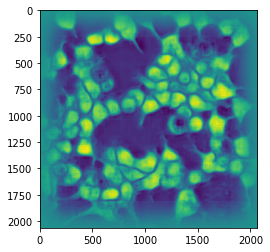

In [31]:
plt.imshow(img[1])
# plt.savefig('/tmp/test.png')

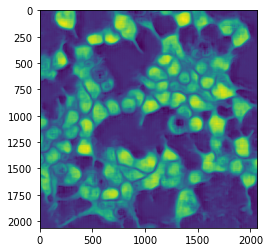

In [33]:
img2 = img/wts
plt.imshow(img2[1])

In [13]:
probs = torch.nn.functional.softmax(torch.from_numpy(img2), dim=0)

In [14]:
probs_fg = probs[1].numpy()
# for th in np.linspace(.5, .85, 8):
#     tmp = (probs_fg > th).astype(np.uint8)*255
#     cv2.imwrite(f'/tmp/th_{th}.png', tmp)

In [63]:
nimg= tmp > 0.7
nimg = nimg.astype(np.uint8)*255
io.imsave('/tmp/mask2.png', nimg)

In [18]:
tmp = skimage.img_as_ubyte(probs_fg)

/home/dhruv/.local/lib/python3.7/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


In [23]:
tmp = cv2.applyColorMap(tmp, cv2.COLORMAP_JET)

cv2.imwrite('/tmp/color.png', tmp)

# Without and input channles at final layer

In [3]:
wo_dir = '/home/dhruv/Cybergut/experiments/24-09-18/val111/logits_mod_4layers/valid/'
wo_fmt = wo_dir+'B - 3(fld 02 wv TL-Brightfield - dsRed)_{}.npy'
wi_dir= '/home/dhruv/Cybergut/experiments/24-09-18/val111/logits/'
wi_fmt = wi_dir+'B - 3(fld 02 wv TL-Brightfield - dsRed)_{}.npy'

In [4]:
img_wo = np.zeros((2, 2064, 2064))
img_wi = np.zeros_like(img_wo)
wts = np.zeros((2, 2064, 2064))

In [9]:
for i, (r, c) in enumerate(zip(rs, cs)):
    npy1 = wo_fmt.format(i)
    npy2 = wi_fmt.format(i)
    logits1 = np.load(npy1)[0]
    logits2 = np.load(npy2)[0]
    logits1 *= kernel
    logits2 *= kernel
    img_wo[:, r:r+516, c:c+516] += logits1
    img_wi[:, r:r+516, c:c+516] += logits2
    wts[:, r:r+516, c:c+516] += kernel

In [10]:
woo = img_wo/wts
wii = img_wi/wts
woo = torch.nn.functional.softmax(torch.from_numpy(woo), dim=0)
wii = torch.nn.functional.softmax(torch.from_numpy(wii), dim=0)
#wo = skimage.img_as_ubyte(woo[1].numpy())
#wi = skimage.img_as_ubyte(wii[1].numpy())
#wo = cv2.applyColorMap(wo, cv2.COLORMAP_JET)
#wi = cv2.applyColorMap(wi, cv2.COLORMAP_JET)
#cv2.imwrite('/home/dhruv/Cybergut/experiments/24-09-18/valid_wo.png', wo)
#cv2.imwrite('/home/dhruv/Cybergut/experiments/24-09-18/valid_wi.png', wi)

In [ ]:
fig = plt.figure(figsize=(256, 600))
fig, axs = fig.subplots(1, 2, sharey=True)
axs[0].imshow(woo[1])
axs[1].imshow(wii[1])
axs[0].axis('off')
axs[1].axis('off')

In [12]:
fgw = woo[1]
fgi = wii[1]
np.save('/home/dhruv/Cybergut/experiments/24-09-18/valid111_wo.npy', fgw)
np.save('/home/dhruv/Cybergut/experiments/24-09-18/valid111_wi.npy', fgi)